In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import librosa
import numpy as np
import os

# ---- 預處理 轉頻譜 ----
def extract_mel_spectrogram(file_path, n_mels=40, hop_length=512):
    y, sr = librosa.load(file_path, sr=16000)

    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, hop_length=hop_length)
    return librosa.power_to_db(mel_spec, ref=np.max)

def normalize_lengths(features):
    """
    長度正則化，截取到最短頻譜的長度。
    """
    min_length = min(f.shape[1] for f in features)
    normalized_features = [f[:, :min_length] for f in features]
    return normalized_features

def load_and_process_data(data_paths, n_mels=40, hop_length=512):

    features = []
    labels = []
    for label, path in enumerate(data_paths):
        for file_name in os.listdir(path):
            file_path = os.path.join(path, file_name)
            mel_spec = extract_mel_spectrogram(file_path, n_mels=n_mels, hop_length=hop_length)
            features.append(mel_spec)
            labels.append(label)
    features = normalize_lengths(features)
    return np.array(features), np.array(labels)

class VoiceDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return torch.tensor(self.features[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)



Reinitialized existing Git repository in /content/Classifier.git/.git/
[main 8ba26bb] Add classifier notebook
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite classifier.ipynb (96%)
Enumerating objects: 7, done.
Counting objects: 100% (7/7), done.
Delta compression using up to 2 threads
Compressing objects: 100% (6/6), done.
Writing objects: 100% (6/6), 49.63 KiB | 9.93 MiB/s, done.
Total 6 (delta 1), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (1/1), done.
remote: error: GH013: Repository rule violations found for refs/heads/main.
remote: 
remote: - GITHUB PUSH PROTECTION
remote:   —————————————————————————————————————————
remote:     Resolve the following violations before pushing again
remote: 
remote:     - Push cannot contain secrets
remote: 
remote:     
remote:      (?) Learn how to resolve a blocked push
remote:      https://docs.github.com/code-security/secret-scanning/working-with-secret-scanning-and-push-protection/working-with-push-protection-fro

In [ ]:

class VoiceClassifier(nn.Module):
    def __init__(self, num_classes):
        super(VoiceClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1_input_size = None
        self.fc1 = None
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.flatten(x, start_dim=1)

        if self.fc1 is None:
            self.fc1_input_size = x.shape[1]
            self.fc1 = nn.Linear(self.fc1_input_size, 128)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return F.softmax(x, dim=1)

#訓練
def train_classifier(features, labels, num_classes, epochs=30, batch_size=8):
    dataset = VoiceDataset(features, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model = VoiceClassifier(num_classes=num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in dataloader:
            inputs, targets = inputs, targets
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss / len(dataloader)}")

    torch.save(model, "classifier_model.pt")
    print("Classifier model saved.")
    return model


In [ ]:
def classify_speaker(input_feature, classifier):
    classifier.eval()
    with torch.no_grad():
        input_tensor = torch.tensor(input_feature, dtype=torch.float32).unsqueeze(0)
        output_probs = classifier(input_tensor)
        predicted_speaker = torch.argmax(output_probs).item()
    return predicted_speaker, output_probs

In [ ]:



    data_paths = [
        "/content/drive/MyDrive/VCC2SF2",
        "/content/drive/MyDrive/VCC2SM2",
        "/content/drive/MyDrive/VCC2SM1"
    ]

    features, labels = load_and_process_data(data_paths)
    num_samples = len(features)
    indices = np.arange(num_samples)
    np.random.shuffle(indices)

    train_size = int(0.8 * num_samples)
    train_indices = indices[:train_size]
    val_indices = indices[train_size:]

    train_features, train_labels = features[train_indices], labels[train_indices]
    val_features, val_labels = features[val_indices], labels[val_indices]

    num_classes = len(data_paths)
    classifier = train_classifier(train_features, train_labels, num_classes=num_classes)


Epoch 1, Loss: 1.1144629001617432
Epoch 2, Loss: 1.089129753112793
Epoch 3, Loss: 1.0578881454467775
Epoch 4, Loss: 0.9741111898422241
Epoch 5, Loss: 0.8252802205085754
Epoch 6, Loss: 0.688438560962677
Epoch 7, Loss: 0.6430150508880615
Epoch 8, Loss: 0.5993263268470764
Epoch 9, Loss: 0.5755213332176209
Epoch 10, Loss: 0.5623941564559937
Epoch 11, Loss: 0.5577044057846069
Epoch 12, Loss: 0.5549396181106567
Epoch 13, Loss: 0.5550816631317139
Epoch 14, Loss: 0.5524740171432495
Epoch 15, Loss: 0.5520663142204285
Epoch 16, Loss: 0.551862027645111
Epoch 17, Loss: 0.551765251159668
Epoch 18, Loss: 0.5517204904556274
Epoch 19, Loss: 0.5516795778274536
Epoch 20, Loss: 0.5516538763046265
Classifier model saved.


In [ ]:
    classifier.eval()
    correct = 0
    total = len(val_labels)
    with torch.no_grad():
      for feature, label in zip(val_features, val_labels):
          predicted_speaker, probs = classify_speaker(feature, classifier)
          print(f"Ground Truth: {label}, Predicted: {predicted_speaker}, Probabilities: {probs}")
          if predicted_speaker == label:
              correct += 1


    accuracy = correct / total * 100
    print(f"Validation Accuracy: {accuracy:.2f}%")


Ground Truth: 0, Predicted: 0, Probabilities: tensor([[9.9997e-01, 2.6241e-05, 7.0763e-06]])
Ground Truth: 2, Predicted: 2, Probabilities: tensor([[1.4673e-06, 6.4580e-04, 9.9935e-01]])
Ground Truth: 0, Predicted: 0, Probabilities: tensor([[9.9999e-01, 5.2942e-06, 2.5404e-07]])
Ground Truth: 0, Predicted: 0, Probabilities: tensor([[1.0000e+00, 2.0835e-06, 1.3309e-07]])
Ground Truth: 2, Predicted: 2, Probabilities: tensor([[2.9267e-06, 8.5421e-05, 9.9991e-01]])
Ground Truth: 0, Predicted: 0, Probabilities: tensor([[1.0000e+00, 5.1883e-08, 1.3556e-09]])
Ground Truth: 2, Predicted: 2, Probabilities: tensor([[1.7613e-07, 7.1034e-05, 9.9993e-01]])
Ground Truth: 1, Predicted: 1, Probabilities: tensor([[3.9974e-03, 9.9508e-01, 9.2123e-04]])
Ground Truth: 1, Predicted: 1, Probabilities: tensor([[1.2347e-05, 9.9999e-01, 8.1003e-07]])
Ground Truth: 1, Predicted: 1, Probabilities: tensor([[3.3855e-05, 9.9994e-01, 2.1863e-05]])
Ground Truth: 2, Predicted: 2, Probabilities: tensor([[5.1767e-05, 7.1

In [ ]:
# 匯入任意新語音
def classify_new_audio(file_path, classifier, min_length=None):
    # 提取頻譜
    input_feature = extract_mel_spectrogram(file_path)
    if min_length is not None:
        input_feature = input_feature[:, :min_length]

    predicted_speaker, probs = classify_speaker(input_feature, classifier)
    print(f"File: {file_path}")
    print(f"Predicted Speaker: {predicted_speaker}")
    print(f"Probabilities: {probs}")
    return predicted_speaker, probs


In [ ]:
if __name__ == "__main__":
    classifier = torch.load("classifier_model.pt")
    min_length = min(feature.shape[1] for feature in features)
    test_file = "/content/30035.wav"
    classify_new_audio(test_file, classifier, min_length=min_length)


File: /content/30035.wav
Predicted Speaker: 1
Probabilities: tensor([[6.8064e-04, 9.9925e-01, 7.1406e-05]])


<ipython-input-49-d3f5e9481c75>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  classifier = torch.load("classifier_model.pt")


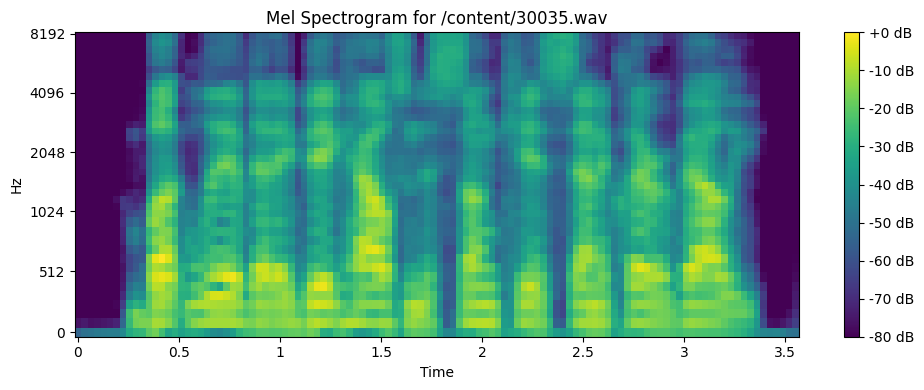

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np


def plot_mel_spectrogram(mel_spec, title="Mel Spectrogram"):

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spec, x_axis='time', y_axis='mel', sr=16000, fmax=8000, cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    test_file = "/content/30035.wav"
    mel_spec = extract_mel_spectrogram(test_file)
    plot_mel_spectrogram(mel_spec, title=f"Mel Spectrogram for {test_file}")


接到cycle gan vc2

In [ ]:
# 假设 gan_models 已定义
gan_models = {0: gan_model_0, 1: gan_model_1, 2: gan_model_2}

# 输入音频路径和输出目录
input_audio_path = "/content/input_audio.wav"
output_audio_dir = "/content/converted_output/"

# 创建输出目录
os.makedirs(output_audio_dir, exist_ok=True)

# 分类器推理
predicted_speaker, output_probs = classify_speaker(feature, classifier)

# 将输入音频连接到对应的 CycleGAN VC2 模型
def connect_to_cyclegan(output_probs, gan_models, input_audio_path, output_audio_dir):
    """
    使用分类器输出的概率连接到相应的 CycleGAN 模型并进行转换。
    """
    # 确认最大概率对应的语者
    selected_speaker = torch.argmax(output_probs).item()
    print(f"Selected Speaker: {selected_speaker}")

    # 使用对应的 CycleGAN 模型
    selected_gan_model = gan_models[selected_speaker]

    # 加载输入音频
    wav, sr = librosa.load(input_audio_path, sr=16000, mono=True)
    wav = preprocess.wav_padding(wav, sr=16000, frame_period=5.0, multiple=4)

    # WORLD 特征提取
    f0, timeaxis, sp, ap = preprocess.world_decompose(wav, fs=16000, frame_period=5.0)
    coded_sp = preprocess.world_encode_spectral_envelop(sp, fs=16000, dim=36)
    coded_sp_transposed = coded_sp.T
    coded_sp_norm = (coded_sp_transposed - selected_gan_model.coded_sps_mean) / selected_gan_model.coded_sps_std

    # 使用 CycleGAN 进行语音转换
    with torch.no_grad():
        coded_sp_norm_tensor = torch.tensor(coded_sp_norm, dtype=torch.float32).unsqueeze(0).cuda()
        coded_sp_converted_norm = selected_gan_model.generator_A2B(coded_sp_norm_tensor).cpu().numpy()

    # 恢复音频特征
    coded_sp_converted = coded_sp_converted_norm.squeeze() * selected_gan_model.coded_sps_std + selected_gan_model.coded_sps_mean
    coded_sp_converted = coded_sp_converted.T
    decoded_sp_converted = preprocess.world_decode_spectral_envelop(coded_sp_converted, fs=16000)

    # WORLD 合成
    wav_converted = preprocess.world_speech_synthesis(f0, decoded_sp_converted, ap, fs=16000, frame_period=5.0)

    # 保存转换后的音频
    output_file = os.path.join(output_audio_dir, f"converted_speaker_{selected_speaker}.wav")
    librosa.output.write_wav(output_file, wav_converted, sr=16000)
    print(f"Converted audio saved at: {output_file}")


# 调用连接函数
connect_to_cyclegan(output_probs, gan_models, input_audio_path, output_audio_dir)
